<table style="float:left">
    <tr>
        <td>
            <img src="images/emlyon.png" style="height:60px; float:left; padding-right:10px; margin-top:5px" />
        </td>
        <td style="">
            <div style="display:inline-block; float:left; text-align:left; width:500px;">
            <h1 style="border-bottom: 1px solid #eeeeee; display:table-cell; padding-bottom:5px;"> Introduction to Deep Learning </h1>
            <a style="" href="https://em-lyon.com/">[emlyon]</a> business school    
            <br/>
            Lyon, Paris | © Saeed VARASTEH
            </div>
        </td>
    </tr>
</table>

<div class="alert-info" style="border-bottom: solid 1px lightgray; background-color:#ece4f5;">
    <img src="images/assignment.png" style="height:60px; float:left; padding-right:10px;" />
    <span style="font-weight:bold; color:#8966b0">
        <h4 style="padding-top:25px;"> FINAL PROJECT </h4>
    </span>
</div>

###  DSAIS Speaker Recognition Application


In this project, you'll build a speaker recognition system to recognize your friends voices.

Let us return to Homework 02. Remember that we built a __fully connected model__ over __averaged mfcc vectors__ extracted from your speech samples? 

Review the questions I asked you at the end of this homework. Now you are able to answer those questions.

__Your task: Improve your speaker recognition model__.

How can you improve the model? The answer is simple: Find a better way to represent the input and extract features from it.

- See if you can play with the parameters of the MFCC extraction function. More MFCC features, or different Mel filter bank parameters (__melkwargs__), or even extracting other speech-related features.

- Currently, we are averaging all MFCC vectors from the signal. It is better to try a different strategy. For example, you can keep a sequence of MFCC features and try RNN models.

- Use existing pre-trained models for audio/speech signals to extract the features from your audio signals. Add a classification head to the model and similar to what we did in our transfer learning session, train the new model. Great speech models are available in "speechbrain", "torchaudio" and "pyannote" libraries.

__Test the model__:

You can use Homework 02 codes as a baseline. To test the model, use three of your friends to see if the model can accurately guess the speaker.

__Extra step (high bounce!)__:

- Build a Python application that recognizes speakers. I will show you how and give an example in class.

- EDA, Apply PCA to embeddings of voices and visualize them, etc. are optional and will increase your score.

Good Luck!

### Installation Instructions

To run this notebook successfully, make sure you have the following libraries installed:

**Core packages**  
`pip install torch torchaudio torchvision`  
`pip install numpy pandas matplotlib scikit-learn tqdm joblib`  

**For dimensionality reduction**  
`pip install umap-learn`  

**For model loading and inference**  
`pip install speechbrain`  

**Optional (if using Jupyter)**  
`pip install ipywidgets`


---

## Project Overview

### Note Before You Begin

---

We do **not need to rerun this training notebook** to test speaker predictions.

I have created a separate notebook — `testing.ipynb` — that loads the best model saved from this notebook and performs **real-time speaker inference**. We can use it to:

- Test with new real samples from our classmates which is saved in the folder "testing"
- Or even record new audio and predict the speaker

⚠️ We are using **MP3 audio files** in this project. If you encounter errors while processing audio (e.g., with `torchaudio.load()`), it's likely because `ffmpeg` is not installed.

To fix this, make sure you have **[Chocolatey](https://chocolatey.org/install)** installed, then open PowerShell as Administrator and run:


choco install ffmpeg


---

### Project Summary: Speaker Identification


This project also explores a **training-free approach**:  
We first demonstrate that **speaker identification is possible using only cosine similarity** between ECAPA-TDNN embeddings.  
Since the pretrained model already maps different speakers into separable regions of the embedding space, this works surprisingly well for small or controlled datasets.

> **This zero-shot method requires no classifier training** —  I simply compare test embeddings to precomputed speaker centroids using cosine similarity.

However, to improve real-world robustness and generalization (e.g., similar voices, background noise), I additionally train a **custom classifier**. This model learns to:
- Separate overlapping speaker profiles
- Adapt better to limited and noisy data
- Provide more consistent predictions


Final Setup: A Hybrid Approach

At inference time, we use a **hybrid strategy**:
- Use the **trained classifier** to get predictions
- Apply a **cosine similarity check** to decide if the prediction is confident
- If the similarity is too low → label it as **"Unknown Speaker"**

This gives us the **best of both worlds**:  
✔️ Efficient classification within the known set  
❌ Robust rejection handling for unknown speakers



> **Note:** The classifier was initially trained as a closed-set classification task — meaning it can only recognize speakers seen during training.
> To handle unseen speakers, we later introduced an open-set recognition mechanism using cosine similarity and thresholding during the inference.

---

### What I've Done

- **Preprocessing and Embedding Extraction**:
  - Audio files are preprocessed and standardized to 16kHz and 12 seconds max duration.
  - We used **SpeechBrain’s ECAPA-TDNN** pretrained model to extract 192-dimensional speaker embeddings.
  - This step was done using **CPU** only for compatibility and simplicity.

- **Model Training**:
  - A custom classifier (`SimpleEmbeddingClassifierBN`) was defined in `model.py` using `torch.nn`.
  - The classifier was trained on the frozen ECAPA embeddings using **GPU** for faster training.
  - Training was done using **Stratified K-Fold Cross-Validation** .

- **Results and Saving**:
  - After training, we saved:
    - Training curves (`.png`) for each fold
    - Metrics in both `.csv` and `.json` formats
    - The best-performing model based on validation accuracy (`.pt`)
  - All results are stored in the `saved_models/` directory for easy reference and reproducibility.

---

### Code Structure

- **`model.py`**:
  - Contains the model architecture and necessary processing logic.
  - This file is reused in the `testing.ipynb` notebook to load the trained classifier and perform speaker inference, ensuring consistent logic between training and testing.

- **`testing.py`**:
  - Created for **inference and real-time testing**.
  - Allows testing the model independently without running the training notebook again.

- **`testing/` folder**:
  - Contains new test audio samples from **four speakers**.
  - You can either:
    - Use the existing new sample files for testing, or
    - Record new audio on-the-go and predict the speaker identity in real-time.

---

### Why Use K-Fold and Save All This?

Using **k-fold cross-validation** provides:
- A **robust and fair estimate** of model performance across multiple splits.
- Insights into how stable or overfitted the model is via accuracy variance.
- Maximum usage of available data for both training and validation.
- A way to save the **best model** across all folds for reliable deployment.

Saving plots, models, and metrics ensures:
- Easy comparison and reproducibility of results.
- A lightweight testing flow (load model → predict → done).
- Full traceability of training decisions and performance history.

---

All key outputs — metrics, plots, models — are saved inside the `saved_models/` directory. This makes it easy to reuse or deploy without rerunning the full training pipeline.


## Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import time
import random
from collections import Counter
import torch
import torchaudio
from sklearn.preprocessing import LabelEncoder
from speechbrain.inference import SpeakerRecognition
from tqdm.notebook import tqdm # Use tqdm.notebook for Jupyter, or just tqdm for terminal
import numpy as np
from models import preprocess_audio, EmbeddingClassifierBN, TARGET_SAMPLE_RATE, MAX_AUDIO_DURATION_SEC, MAX_SAMPLES
import joblib
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import TensorDataset
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset, DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap




from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import pandas as pd
import json
import matplotlib.pyplot as plt



# Set seed for reproducibility
SEED = 42
import numpy as np, random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

c:\Users\jermi\.conda\envs\pytorch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


c:\Users\jermi\.conda\envs\pytorch_env\lib\site-packages\IPython\extensions\autoreload.py:211: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if not hasattr(module, "__file__") or module.__file__ is None:


## Loading

In [3]:
DATA_DIR = "./Speakers/Speakers/train/"
AUDIO_EXTENSION = "*.mp3"  

# Gather all file paths and corresponding speaker labels
all_filepaths = []
all_labels = []

def list_not_hidden(directory):
    return [f for f in os.listdir(directory) if not f.startswith(('.', '_'))]

speaker_dirs = sorted([d for d in list_not_hidden(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])

if not speaker_dirs:
    raise ValueError(f"No speaker directories found in {DATA_DIR}")

for speaker in speaker_dirs:
    speaker_path = os.path.join(DATA_DIR, speaker)
    speaker_files = glob.glob(os.path.join(speaker_path, AUDIO_EXTENSION))
    speaker_files = sorted(list(set(speaker_files)))  # Remove duplicates, sort

    if not speaker_files:
        print(f" No audio files found for {speaker}")
        continue

    for f in speaker_files:
        all_filepaths.append(f)
        all_labels.append(speaker)

print(f" Loaded {len(all_filepaths)} files from {len(set(all_labels))} speakers")
print("Speaker distribution:", Counter(all_labels))


 Loaded 170 files from 34 speakers
Speaker distribution: Counter({'abdoulaye': 5, 'abhishek': 5, 'adam': 5, 'adesh': 5, 'agathe': 5, 'arisa': 5, 'arthur': 5, 'ayoub': 5, 'camille': 5, 'charlotte': 5, 'dilara': 5, 'ekaterina': 5, 'ella': 5, 'hadi': 5, 'henry': 5, 'himanshu': 5, 'hugo': 5, 'jermiah': 5, 'jintian': 5, 'joaquin': 5, 'kp': 5, 'lou': 5, 'marysheeba': 5, 'matilde': 5, 'maude': 5, 'piercarlo': 5, 'saeed': 5, 'sicheng': 5, 'siwen': 5, 'tim': 5, 'walid': 5, 'yanlin': 5, 'yiwei': 5, 'yuying': 5})


## Encoding the Labels

In [4]:
# Label encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)
print(f"Encoded {len(set(encoded_labels))} unique speakers")

# Mappings
index_to_name = dict(enumerate(label_encoder.classes_))

Encoded 34 unique speakers


In [5]:
label_encoder.classes_

array(['abdoulaye', 'abhishek', 'adam', 'adesh', 'agathe', 'arisa',
       'arthur', 'ayoub', 'camille', 'charlotte', 'dilara', 'ekaterina',
       'ella', 'hadi', 'henry', 'himanshu', 'hugo', 'jermiah', 'jintian',
       'joaquin', 'kp', 'lou', 'marysheeba', 'matilde', 'maude',
       'piercarlo', 'saeed', 'sicheng', 'siwen', 'tim', 'walid', 'yanlin',
       'yiwei', 'yuying'], dtype='<U10')

In [6]:
index_to_name

{0: 'abdoulaye',
 1: 'abhishek',
 2: 'adam',
 3: 'adesh',
 4: 'agathe',
 5: 'arisa',
 6: 'arthur',
 7: 'ayoub',
 8: 'camille',
 9: 'charlotte',
 10: 'dilara',
 11: 'ekaterina',
 12: 'ella',
 13: 'hadi',
 14: 'henry',
 15: 'himanshu',
 16: 'hugo',
 17: 'jermiah',
 18: 'jintian',
 19: 'joaquin',
 20: 'kp',
 21: 'lou',
 22: 'marysheeba',
 23: 'matilde',
 24: 'maude',
 25: 'piercarlo',
 26: 'saeed',
 27: 'sicheng',
 28: 'siwen',
 29: 'tim',
 30: 'walid',
 31: 'yanlin',
 32: 'yiwei',
 33: 'yuying'}

### Verifying the encoding

In [7]:
print("Example names and their encoded values:")
for i in range(20):
    print(f"{all_filepaths[i]} ⟶ {all_labels[i]} ⟶ Encoded: {encoded_labels[i]}")


Example names and their encoded values:
./Speakers/Speakers/train/abdoulaye\sentence_1.mp3 ⟶ abdoulaye ⟶ Encoded: 0
./Speakers/Speakers/train/abdoulaye\sentence_2.mp3 ⟶ abdoulaye ⟶ Encoded: 0
./Speakers/Speakers/train/abdoulaye\sentence_3.mp3 ⟶ abdoulaye ⟶ Encoded: 0
./Speakers/Speakers/train/abdoulaye\sentence_4.mp3 ⟶ abdoulaye ⟶ Encoded: 0
./Speakers/Speakers/train/abdoulaye\sentence_5.mp3 ⟶ abdoulaye ⟶ Encoded: 0
./Speakers/Speakers/train/abhishek\recording1.mp3 ⟶ abhishek ⟶ Encoded: 1
./Speakers/Speakers/train/abhishek\recording2.mp3 ⟶ abhishek ⟶ Encoded: 1
./Speakers/Speakers/train/abhishek\recording3.mp3 ⟶ abhishek ⟶ Encoded: 1
./Speakers/Speakers/train/abhishek\recording4.mp3 ⟶ abhishek ⟶ Encoded: 1
./Speakers/Speakers/train/abhishek\recording5.mp3 ⟶ abhishek ⟶ Encoded: 1
./Speakers/Speakers/train/adam\Record (online-voice-recorder.com)-2.mp3 ⟶ adam ⟶ Encoded: 2
./Speakers/Speakers/train/adam\Record (online-voice-recorder.com)-3.mp3 ⟶ adam ⟶ Encoded: 2
./Speakers/Speakers/train/

In [8]:
joblib.dump(label_encoder, "label_encoder.pkl")
print("Saved label_encoder.pkl")

Saved label_encoder.pkl


## Analysing the audios ( EDA )

Calculating durations...


c:\Users\jermi\.conda\envs\pytorch_env\lib\site-packages\torchaudio\_backend\soundfile_backend.py:71: UserWarning: The MPEG_LAYER_III subtype is unknown to TorchAudio. As a result, the bits_per_sample attribute will be set to 0. If you are seeing this warning, please report by opening an issue on github (after checking for existing/closed ones). You may otherwise ignore this warning.
  warnings.warn(



Duration calculation attempt complete.

--- Audio Duration Statistics (Based on 170 successfully processed files) ---
Min duration:    2.76 seconds
Max duration:    12.07 seconds
Mean duration:   6.33 seconds
Median duration: 5.90 seconds
95th percentile: 11.01 seconds
99th percentile: 12.05 seconds


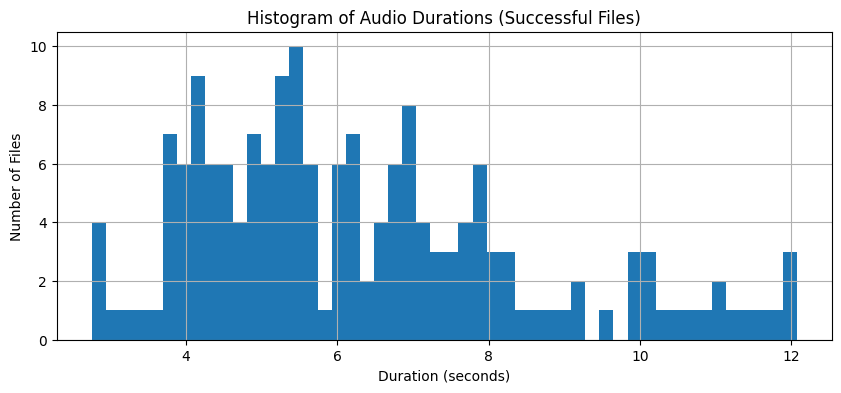

In [9]:
import matplotlib.pyplot as plt
if 'all_filepaths' in locals() and all_filepaths:
    durations = []
    error_files = [] 
    print("Calculating durations...")

    for i, fpath in enumerate(all_filepaths):
        try:
            # --- Attempting to use the path directly ---
            info = torchaudio.info(fpath)
            duration = info.num_frames / info.sample_rate
            durations.append(duration)

        except Exception as e:
            print(f"--- ERROR ---")
            print(f"Path tried: '{fpath}'")
            print(f"Error: {e}")
            print(f"-------------")
            error_files.append(fpath)

    

    print("\nDuration calculation attempt complete.")

    if error_files:
        print(f"WARNING: Encountered errors processing {len(error_files)} out of {len(all_filepaths)} files.")
       

    if durations:
        durations_np = np.array(durations)
        print(f"\n--- Audio Duration Statistics (Based on {len(durations_np)} successfully processed files) ---")
        print(f"Min duration:    {durations_np.min():.2f} seconds")
        print(f"Max duration:    {durations_np.max():.2f} seconds")
        print(f"Mean duration:   {durations_np.mean():.2f} seconds")
        print(f"Median duration: {np.median(durations_np):.2f} seconds")
        print(f"95th percentile: {np.percentile(durations_np, 95):.2f} seconds")
        print(f"99th percentile: {np.percentile(durations_np, 99):.2f} seconds")

        plt.figure(figsize=(10, 4))
        plt.hist(durations_np, bins=50)
        plt.title("Histogram of Audio Durations (Successful Files)")
        plt.xlabel("Duration (seconds)")
        plt.ylabel("Number of Files")
        plt.grid(True)
        plt.show()
    elif not error_files:
        print("No durations calculated, but no errors reported? Check data.")
    else:
         print("No valid durations calculated because all files resulted in errors.")

else:
    print("Variable 'all_filepaths' not found or empty. Cannot calculate durations.")
    print("Please ensure the previous data loading cell (Cell 3) ran successfully.")

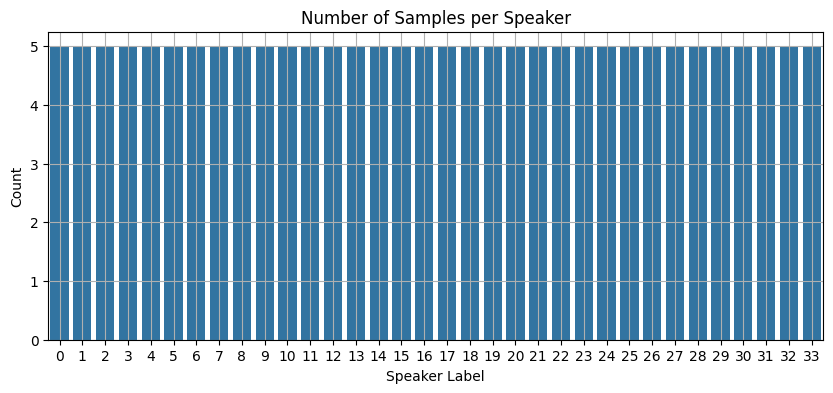

In [10]:
import seaborn as sns
import pandas as pd

# Assuming `encoded_labels` or your label list is available
label_df = pd.DataFrame({'Speaker': encoded_labels})
plt.figure(figsize=(10, 4))
sns.countplot(data=label_df, x='Speaker')
plt.title("Number of Samples per Speaker")
plt.xlabel("Speaker Label")
plt.ylabel("Count")
plt.grid(True)
plt.show()


## Model Downloading

In [11]:
# Load ECAPA-TDNN speaker embedding model
verification = SpeakerRecognition.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb"
)

print(f" ECAPA-TDNN model loaded")


c:\Users\jermi\.conda\envs\pytorch_env\lib\site-packages\speechbrain\utils\autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
c:\Users\jermi\.conda\envs\pytorch_env\lib\site-packages\speechbrain\utils\checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allow

 ECAPA-TDNN model loaded


## Create Embeddings

The preprocess_audio function supports both zero-padding and repeat-padding through a toggle flag (use_repeat_padding) to flexibly handle short audio clips without injecting silence.

In [12]:
# === Constants ===
TARGET_SAMPLE_RATE = 16000
MAX_AUDIO_DURATION_SEC = 12
MAX_SAMPLES = TARGET_SAMPLE_RATE * MAX_AUDIO_DURATION_SEC

# === Load Pretrained ECAPA-TDNN Model ===
verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")
verification.eval()


# === Prepare Directory to Save Embeddings ===
embedding_dir = "saved_embeddings"
os.makedirs(embedding_dir, exist_ok=True)

embedding_paths = []
new_labels = []

for filepath, label in tqdm(zip(all_filepaths, encoded_labels), total=len(all_filepaths), desc="Saving Embeddings"):
    waveform = preprocess_audio(filepath, use_repeat_padding=True)
    if waveform is None:
        continue

    with torch.no_grad():
        try:
            emb = verification.encode_batch(waveform, wav_lens=torch.tensor([1.0]))
            emb = emb.view(-1)  # Shape: [192]
        
        except Exception as e:
            print(f" Model error for {filepath}: {e}")
            continue

    # Save with unique name: speaker_folder_audiofilename.pt
    speaker_name = os.path.basename(os.path.dirname(filepath))
    base_name = os.path.splitext(os.path.basename(filepath))[0]
    emb_filename = f"{speaker_name}_{base_name}.pt"
    emb_path = os.path.join(embedding_dir, emb_filename)

    torch.save({
        "embedding": emb,
        "label": label
    }, emb_path)

    embedding_paths.append(emb_path)
    new_labels.append(label)

print(f"\n Saved {len(embedding_paths)} uniquely named embedding files in: {embedding_dir}")


Saving Embeddings: 100%|██████████| 170/170 [01:44<00:00,  1.63it/s]


 Saved 170 uniquely named embedding files in: saved_embeddings


In [13]:
# === Save Combined Dataset with Filenames ===
all_embeddings = []
all_labels = []
all_filenames = []

for emb_path in embedding_paths:
    try:
        data = torch.load(emb_path)
        all_embeddings.append(data["embedding"])
        all_labels.append(data["label"])
        all_filenames.append(os.path.basename(emb_path))  
    except Exception as e:
        print(f" Skipping file during merge: {emb_path}, error: {e}")

all_embeddings_tensor = torch.stack(all_embeddings)
all_labels_tensor = torch.tensor(all_labels)

torch.save({
    "embeddings": all_embeddings_tensor,
    "labels": all_labels_tensor,
    "filenames": all_filenames
}, "final_dataset.pt")

print(f" Combined dataset saved to final_dataset.pt with shape {all_embeddings_tensor.shape}")

 Combined dataset saved to final_dataset.pt with shape torch.Size([170, 192])


C:\Users\jermi\AppData\Local\Temp\ipykernel_45296\3147344642.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(emb_path)


## Understanding the Embeddings ( PCA , t-SNE , U-Map )

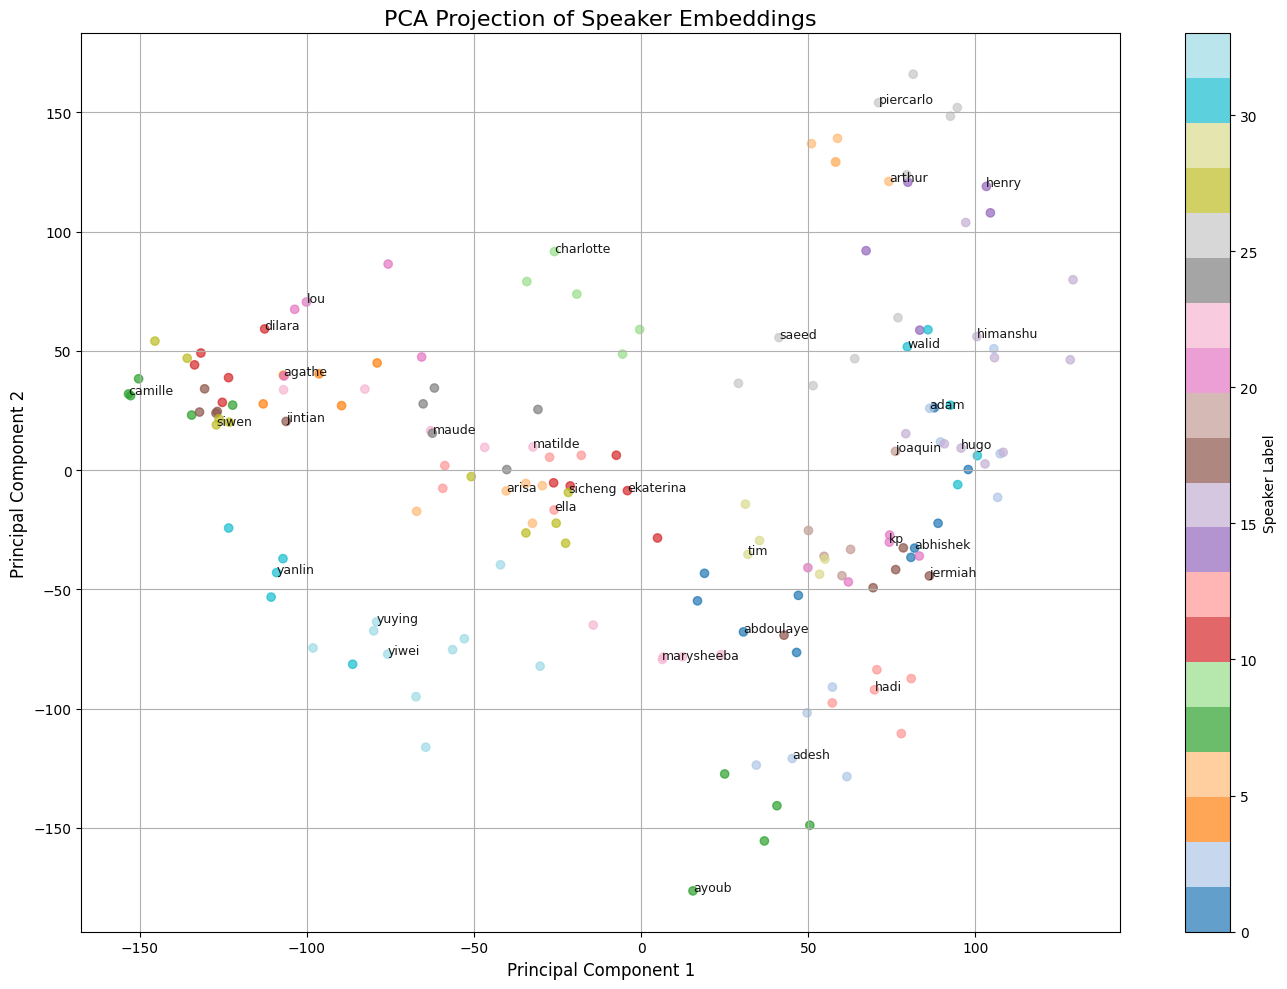

In [14]:
# Convert tensors to numpy arrays
Emd_X = all_embeddings_tensor.cpu().numpy()
y_plot = all_labels_tensor.cpu().numpy()

# Map numeric labels to speaker names
speaker_names = [index_to_name[label] for label in y_plot]

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Emd_X)

# Create a DataFrame for easy plotting
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Speaker': speaker_names
})

# Plotting
plt.figure(figsize=(14, 10))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=y_plot, cmap='tab20', alpha=0.7)
plt.title("PCA Projection of Speaker Embeddings", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.grid(True)
plt.colorbar(scatter, label="Speaker Label")

# Annotate only one point per speaker
for name, group in pca_df.groupby("Speaker"):
    sample = group.sample(1, random_state=42)
    plt.annotate(
        name,
        (sample['PC1'].values[0], sample['PC2'].values[0]),
        fontsize=9,
        alpha=0.9
    )

plt.tight_layout()
plt.show()


c:\Users\jermi\.conda\envs\pytorch_env\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jermi\.conda\envs\pytorch_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\jermi\.conda\envs\pytorch_env\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\jermi\.conda\envs\pytorch_env\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\jermi\.conda\envs\pytorch_env\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePr

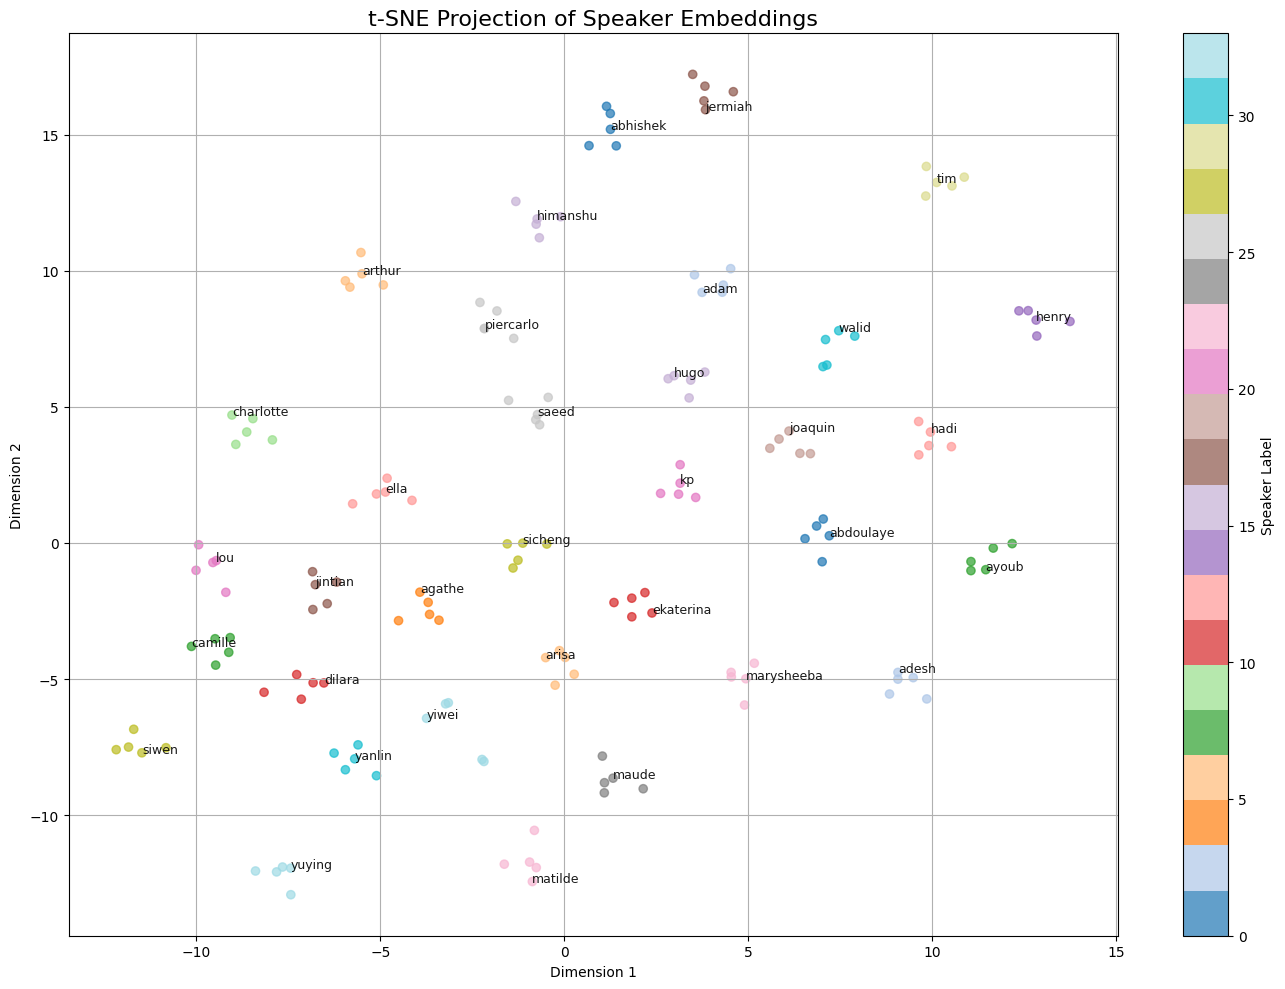

In [15]:
# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(Emd_X)

# Create DataFrame
tsne_df = pd.DataFrame({
    'Dim1': X_tsne[:, 0],
    'Dim2': X_tsne[:, 1],
    'Speaker': speaker_names
})

plt.figure(figsize=(14, 10))
scatter = plt.scatter(tsne_df['Dim1'], tsne_df['Dim2'], c=y_plot, cmap='tab20', alpha=0.7)
plt.title("t-SNE Projection of Speaker Embeddings", fontsize=16)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.colorbar(scatter, label="Speaker Label")

# Label only one point per speaker (random or first)
for name, group in tsne_df.groupby("Speaker"):
    sample = group.sample(1, random_state=42)  # pick 1 random sample per speaker
    plt.annotate(
        name,
        (sample['Dim1'].values[0], sample['Dim2'].values[0]),
        fontsize=9,
        alpha=0.9
    )

plt.tight_layout()
plt.show()


c:\Users\jermi\.conda\envs\pytorch_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jermi\.conda\envs\pytorch_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


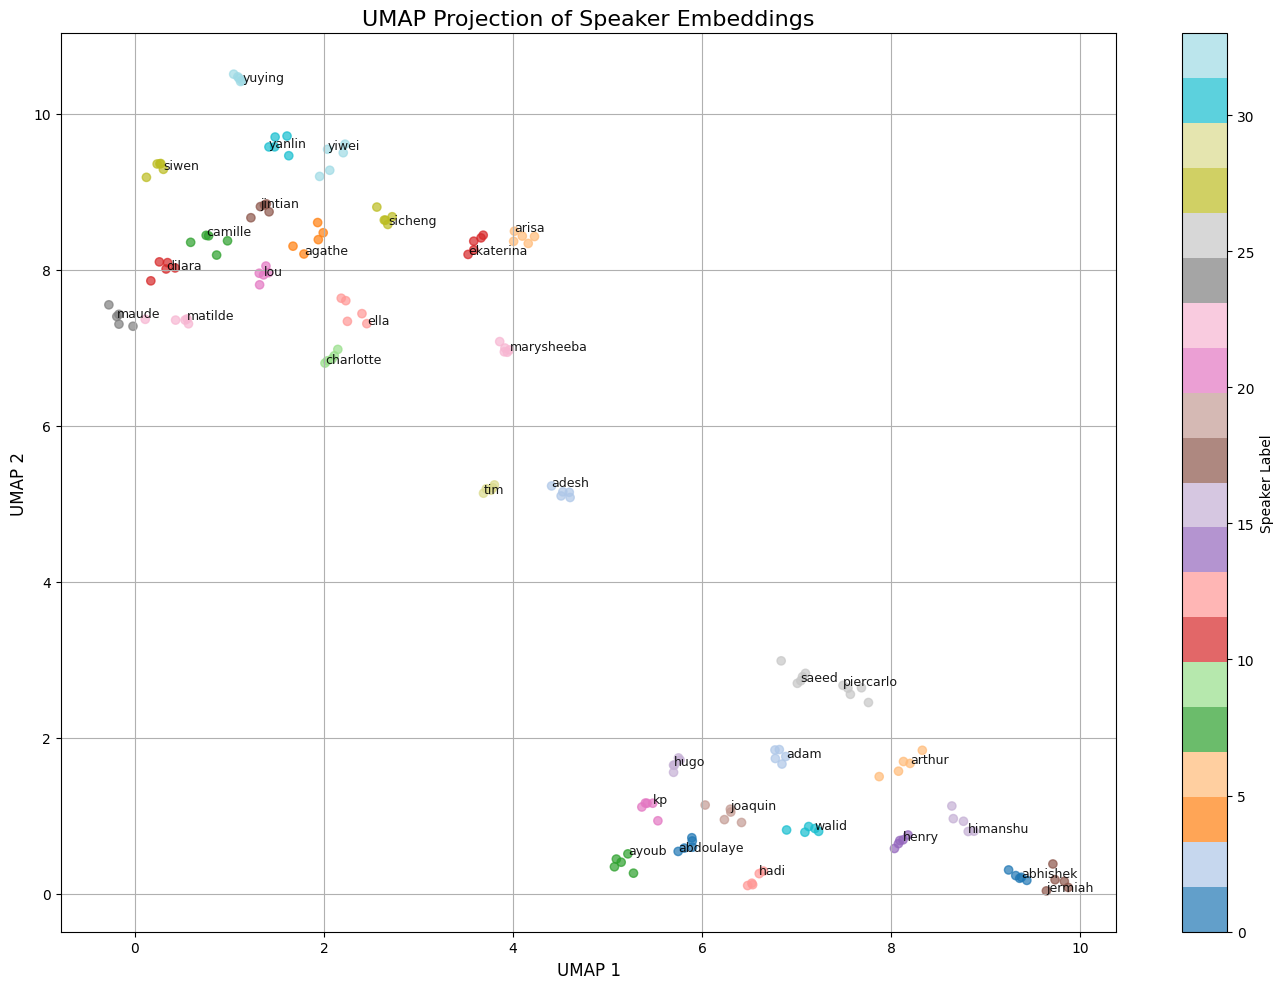

In [16]:
# Run UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(Emd_X)

# Create DataFrame for plotting
umap_df = pd.DataFrame({
    'Dim1': X_umap[:, 0],
    'Dim2': X_umap[:, 1],
    'Speaker': speaker_names
})

plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    umap_df['Dim1'],
    umap_df['Dim2'],
    c=y_plot,
    cmap='tab20',
    alpha=0.7
)

plt.title("UMAP Projection of Speaker Embeddings", fontsize=16)
plt.xlabel("UMAP 1", fontsize=12)
plt.ylabel("UMAP 2", fontsize=12)
plt.grid(True)
plt.colorbar(scatter, label="Speaker Label")

# Label one sample per speaker
for name, group in umap_df.groupby("Speaker"):
    sample = group.sample(1, random_state=42)
    plt.annotate(
        name,
        (sample['Dim1'].values[0], sample['Dim2'].values[0]),
        fontsize=9,
        alpha=0.9
    )

plt.tight_layout()
plt.show()


###  Interpretation Based on PCA, t-SNE, and UMAP Graphs

We visualized the 192-dimensional speaker embeddings generated by ECAPA-TDNN using PCA, t-SNE, and UMAP. Here's what we observe from each plot:

---

####  PCA Projection
- In the PCA plot, **speaker clusters are not well separated**, and several speakers appear in overlapping regions.
- For example, speakers like `marysheeba`, `tim`, and `matilde` are scattered across the space, suggesting poor cluster definition.
- This confirms that PCA, being a linear technique, **fails to capture the non-linear structure** of ECAPA-TDNN embeddings.

---

####  t-SNE Projection
- The t-SNE visualization shows **tight, compact clusters** for most speakers.
- For example:
  - `ekaterina`, `arisa`, and `hadi` form distinct groups.
  - Speakers like `yuying`, `abdoulaye`, and `charlotte` are well-isolated from others.

---

####  UMAP Projection
- UMAP also reveals **well-separated clusters**, similar to t-SNE, while maintaining a more balanced **global layout**.
- Speakers occupy distinct regions.
- Even closely placed speakers (e.g., `kp` and `hugo`) still show enough separation to identify boundaries.

---

###  Final Takeaway

- **t-SNE and UMAP clearly showed** that the ECAPA-TDNN embeddings form **mostly distinct and well-separated clusters** for each speaker.
- The spacing between clusters indicates that the embeddings are **highly discriminative**, i.e., different speakers occupy different regions in the latent space.
- A few similar-sounding speakers appear spatially close, but clusters remain identifiable.
- These visualizations confirm that our feature extraction pipeline is effective — the ECAPA-TDNN model has learned to represent speakers in a meaningful, structured space.


## Training

In [17]:
# Load the dataset
data = torch.load("final_dataset.pt")
X = data["embeddings"]
y = data["labels"]
names = data["filenames"]

# Basic summary
print(" Total samples:", X.shape[0])
print(" Embedding dimension:", X.shape[1])


print("\n Sample Overview:")
for i in range(15):
    print(f"{i+1}. File: {names[i]}")
    print(f"   Label: {y[i].item()}")
    print(f"   Embedding (first 5 dims): {X[i][:5].tolist()}")


 Total samples: 170
 Embedding dimension: 192

 Sample Overview:
1. File: abdoulaye_sentence_1.pt
   Label: 0
   Embedding (first 5 dims): [-25.43046760559082, 13.000904083251953, 6.031268119812012, 9.37302017211914, 14.361474990844727]
2. File: abdoulaye_sentence_2.pt
   Label: 0
   Embedding (first 5 dims): [-16.78336524963379, -1.6184083223342896, -2.0767388343811035, -8.180646896362305, 21.315921783447266]
3. File: abdoulaye_sentence_3.pt
   Label: 0
   Embedding (first 5 dims): [-11.474791526794434, -9.470820426940918, 4.480825424194336, 25.84697914123535, 3.3878767490386963]
4. File: abdoulaye_sentence_4.pt
   Label: 0
   Embedding (first 5 dims): [-17.5274658203125, 33.1462516784668, 9.477747917175293, -6.532566547393799, 25.546205520629883]
5. File: abdoulaye_sentence_5.pt
   Label: 0
   Embedding (first 5 dims): [-8.311619758605957, 32.87450408935547, -33.67899703979492, 5.557191848754883, 38.04629135131836]
6. File: abhishek_recording1.pt
   Label: 1
   Embedding (first 5 dim

C:\Users\jermi\AppData\Local\Temp\ipykernel_45296\2529009372.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("final_dataset.pt")


In [18]:
print(type(X), X.shape)
print(type(y), y.shape)


<class 'torch.Tensor'> torch.Size([170, 192])
<class 'torch.Tensor'> torch.Size([170])


In [19]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(X, y)  

In [20]:
# Parameters
NUM_FOLDS = 5
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
EMBEDDING_DIM = 192
NUM_CLASSES = len(torch.unique(y))

In [21]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc


In [22]:
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
full_dataset = TensorDataset(X, y)
fold_accuracies = []


===== Fold 1/5 =====


c:\Users\jermi\.conda\envs\pytorch_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01: Train Acc=3.68%, Val Acc=11.76%
Epoch 02: Train Acc=4.41%, Val Acc=17.65%
Epoch 03: Train Acc=6.62%, Val Acc=17.65%
Epoch 04: Train Acc=10.29%, Val Acc=20.59%
Epoch 05: Train Acc=11.76%, Val Acc=20.59%
Epoch 06: Train Acc=7.35%, Val Acc=23.53%
Epoch 07: Train Acc=12.50%, Val Acc=32.35%
Epoch 08: Train Acc=20.59%, Val Acc=38.24%
Epoch 09: Train Acc=20.59%, Val Acc=41.18%
Epoch 10: Train Acc=30.15%, Val Acc=50.00%
Epoch 11: Train Acc=33.09%, Val Acc=61.76%
Epoch 12: Train Acc=38.24%, Val Acc=64.71%
Epoch 13: Train Acc=36.03%, Val Acc=67.65%
Epoch 14: Train Acc=39.71%, Val Acc=79.41%
Epoch 15: Train Acc=43.38%, Val Acc=76.47%
Epoch 16: Train Acc=46.32%, Val Acc=88.24%
Epoch 17: Train Acc=52.94%, Val Acc=91.18%
Epoch 18: Train Acc=58.09%, Val Acc=91.18%
Epoch 19: Train Acc=63.24%, Val Acc=94.12%
Epoch 20: Train Acc=63.97%, Val Acc=97.06%
Epoch 21: Train Acc=72.79%, Val Acc=97.06%
Epoch 22: Train Acc=66.18%, Val Acc=97.06%
Epoch 23: Train Acc=75.00%, Val Acc=97.06%
Epoch 24: Train

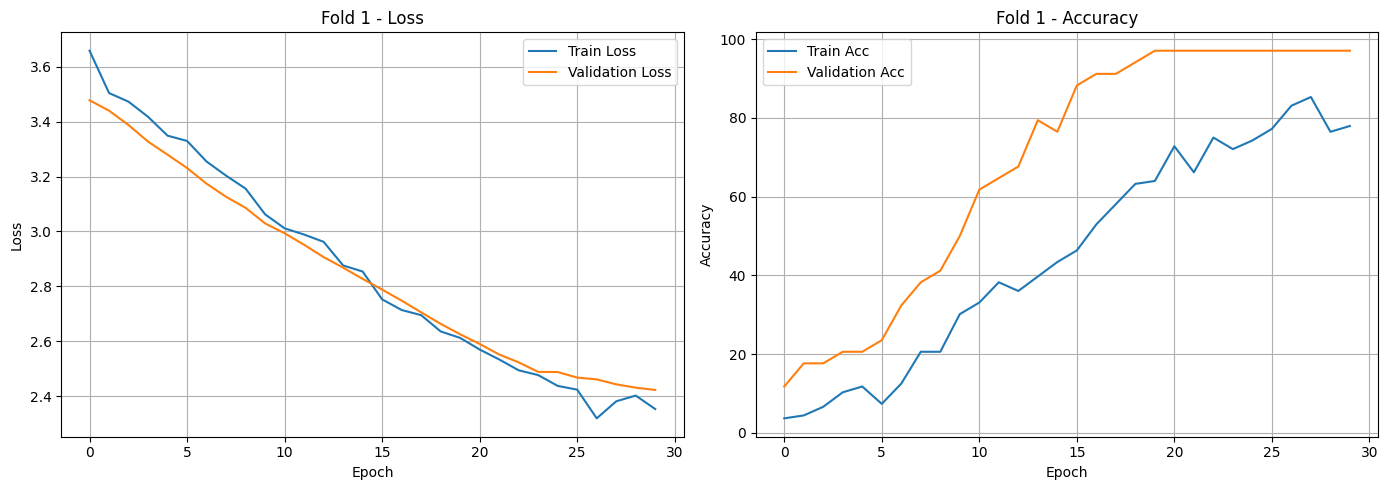


===== Fold 2/5 =====
Epoch 01: Train Acc=3.68%, Val Acc=2.94%
Epoch 02: Train Acc=4.41%, Val Acc=11.76%
Epoch 03: Train Acc=11.03%, Val Acc=20.59%
Epoch 04: Train Acc=5.88%, Val Acc=23.53%
Epoch 05: Train Acc=13.97%, Val Acc=35.29%
Epoch 06: Train Acc=11.76%, Val Acc=38.24%
Epoch 07: Train Acc=17.65%, Val Acc=38.24%
Epoch 08: Train Acc=16.18%, Val Acc=41.18%
Epoch 09: Train Acc=23.53%, Val Acc=41.18%
Epoch 10: Train Acc=20.59%, Val Acc=41.18%
Epoch 11: Train Acc=27.21%, Val Acc=47.06%
Epoch 12: Train Acc=29.41%, Val Acc=50.00%
Epoch 13: Train Acc=33.09%, Val Acc=52.94%
Epoch 14: Train Acc=29.41%, Val Acc=61.76%
Epoch 15: Train Acc=38.97%, Val Acc=58.82%
Epoch 16: Train Acc=44.85%, Val Acc=73.53%
Epoch 17: Train Acc=52.21%, Val Acc=82.35%
Epoch 18: Train Acc=54.41%, Val Acc=85.29%
Epoch 19: Train Acc=55.88%, Val Acc=85.29%
Epoch 20: Train Acc=68.38%, Val Acc=88.24%
Epoch 21: Train Acc=62.50%, Val Acc=85.29%
Epoch 22: Train Acc=71.32%, Val Acc=88.24%
Epoch 23: Train Acc=68.38%, Val Acc=

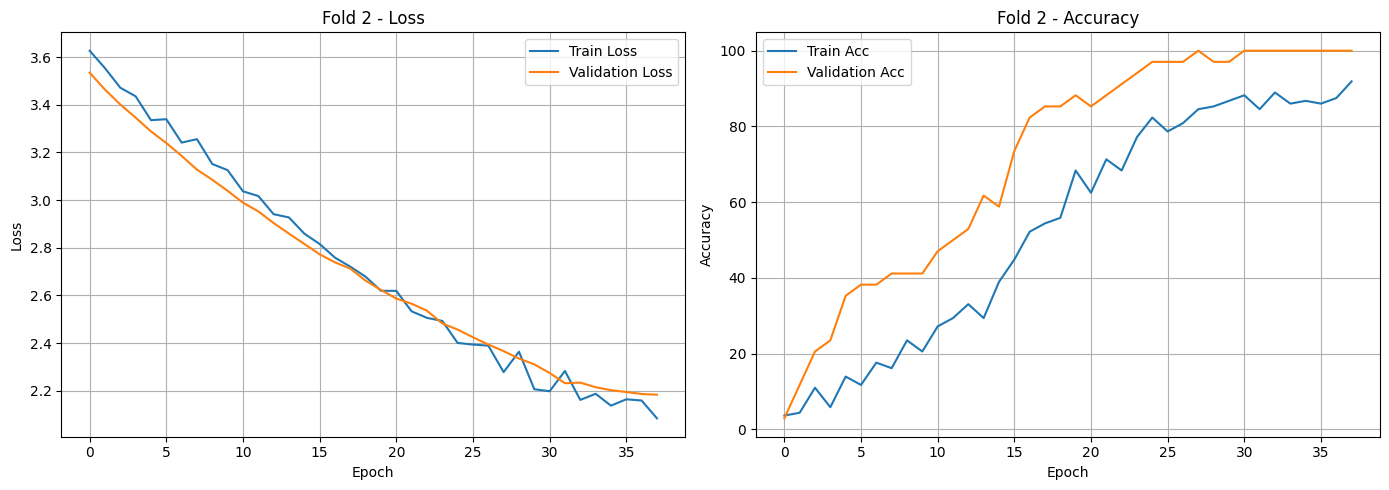


===== Fold 3/5 =====
Epoch 01: Train Acc=2.21%, Val Acc=5.88%
Epoch 02: Train Acc=4.41%, Val Acc=11.76%
Epoch 03: Train Acc=5.88%, Val Acc=14.71%
Epoch 04: Train Acc=8.82%, Val Acc=17.65%
Epoch 05: Train Acc=7.35%, Val Acc=17.65%
Epoch 06: Train Acc=11.03%, Val Acc=23.53%
Epoch 07: Train Acc=12.50%, Val Acc=26.47%
Epoch 08: Train Acc=19.85%, Val Acc=35.29%
Epoch 09: Train Acc=17.65%, Val Acc=41.18%
Epoch 10: Train Acc=23.53%, Val Acc=44.12%
Epoch 11: Train Acc=34.56%, Val Acc=50.00%
Epoch 12: Train Acc=30.15%, Val Acc=50.00%
Epoch 13: Train Acc=33.82%, Val Acc=64.71%
Epoch 14: Train Acc=41.18%, Val Acc=73.53%
Epoch 15: Train Acc=41.91%, Val Acc=82.35%
Epoch 16: Train Acc=55.88%, Val Acc=85.29%
Epoch 17: Train Acc=53.68%, Val Acc=85.29%
Epoch 18: Train Acc=53.68%, Val Acc=85.29%
Epoch 19: Train Acc=61.76%, Val Acc=85.29%
Epoch 20: Train Acc=55.88%, Val Acc=85.29%
Epoch 21: Train Acc=66.91%, Val Acc=94.12%
Epoch 22: Train Acc=68.38%, Val Acc=94.12%
Epoch 23: Train Acc=70.59%, Val Acc=94

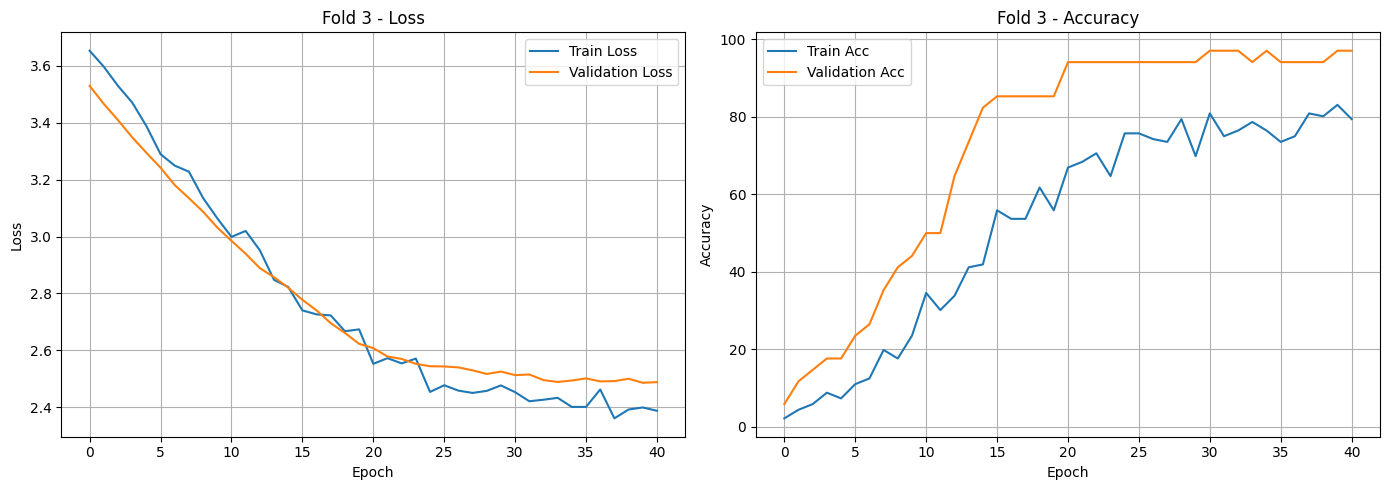


===== Fold 4/5 =====
Epoch 01: Train Acc=5.15%, Val Acc=0.00%
Epoch 02: Train Acc=5.15%, Val Acc=2.94%
Epoch 03: Train Acc=13.97%, Val Acc=2.94%
Epoch 04: Train Acc=8.82%, Val Acc=2.94%
Epoch 05: Train Acc=9.56%, Val Acc=11.76%
Epoch 06: Train Acc=11.03%, Val Acc=23.53%
Epoch 07: Train Acc=14.71%, Val Acc=29.41%
Epoch 08: Train Acc=21.32%, Val Acc=41.18%
Epoch 09: Train Acc=26.47%, Val Acc=47.06%
Epoch 10: Train Acc=27.21%, Val Acc=50.00%
Epoch 11: Train Acc=33.09%, Val Acc=52.94%
Epoch 12: Train Acc=36.76%, Val Acc=58.82%
Epoch 13: Train Acc=36.03%, Val Acc=58.82%
Epoch 14: Train Acc=45.59%, Val Acc=64.71%
Epoch 15: Train Acc=40.44%, Val Acc=76.47%
Epoch 16: Train Acc=50.00%, Val Acc=79.41%
Epoch 17: Train Acc=59.56%, Val Acc=79.41%
Epoch 18: Train Acc=58.82%, Val Acc=82.35%
Epoch 19: Train Acc=56.62%, Val Acc=82.35%
Epoch 20: Train Acc=66.91%, Val Acc=97.06%
Epoch 21: Train Acc=68.38%, Val Acc=94.12%
Epoch 22: Train Acc=72.79%, Val Acc=94.12%
Epoch 23: Train Acc=73.53%, Val Acc=94.1

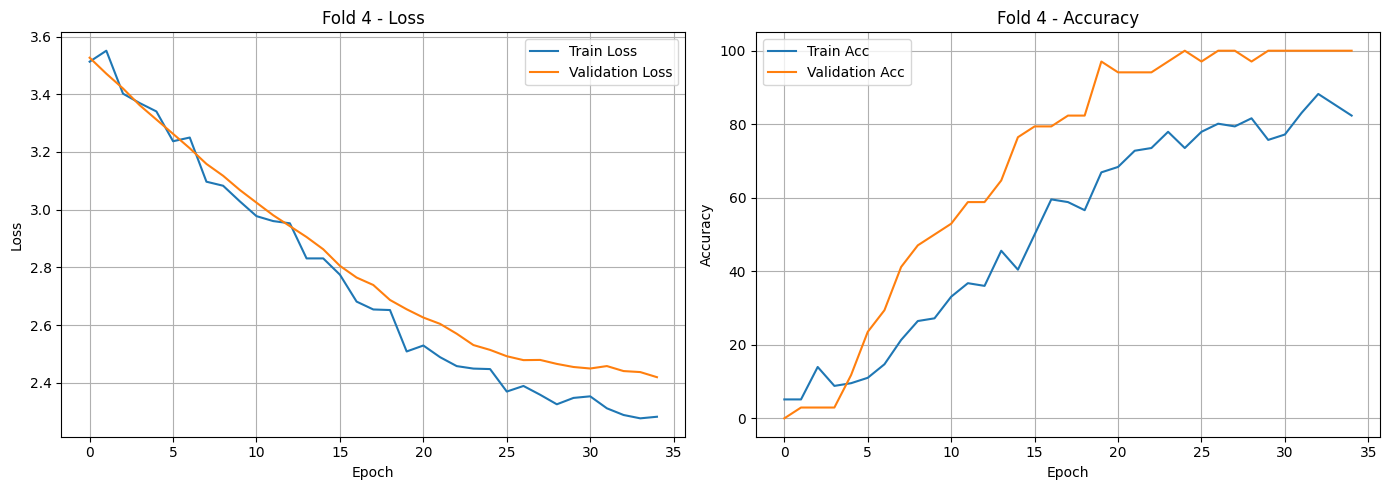


===== Fold 5/5 =====
Epoch 01: Train Acc=2.21%, Val Acc=0.00%
Epoch 02: Train Acc=5.15%, Val Acc=0.00%
Epoch 03: Train Acc=2.21%, Val Acc=8.82%
Epoch 04: Train Acc=6.62%, Val Acc=17.65%
Epoch 05: Train Acc=12.50%, Val Acc=17.65%
Epoch 06: Train Acc=15.44%, Val Acc=23.53%
Epoch 07: Train Acc=16.18%, Val Acc=41.18%
Epoch 08: Train Acc=20.59%, Val Acc=41.18%
Epoch 09: Train Acc=23.53%, Val Acc=44.12%
Epoch 10: Train Acc=22.79%, Val Acc=50.00%
Epoch 11: Train Acc=30.88%, Val Acc=55.88%
Epoch 12: Train Acc=33.09%, Val Acc=58.82%
Epoch 13: Train Acc=43.38%, Val Acc=61.76%
Epoch 14: Train Acc=40.44%, Val Acc=73.53%
Epoch 15: Train Acc=45.59%, Val Acc=76.47%
Epoch 16: Train Acc=52.21%, Val Acc=76.47%
Epoch 17: Train Acc=52.21%, Val Acc=82.35%
Epoch 18: Train Acc=59.56%, Val Acc=85.29%
Epoch 19: Train Acc=57.35%, Val Acc=85.29%
Epoch 20: Train Acc=63.97%, Val Acc=88.24%
Epoch 21: Train Acc=75.74%, Val Acc=91.18%
Epoch 22: Train Acc=74.26%, Val Acc=94.12%
Epoch 23: Train Acc=76.47%, Val Acc=97.

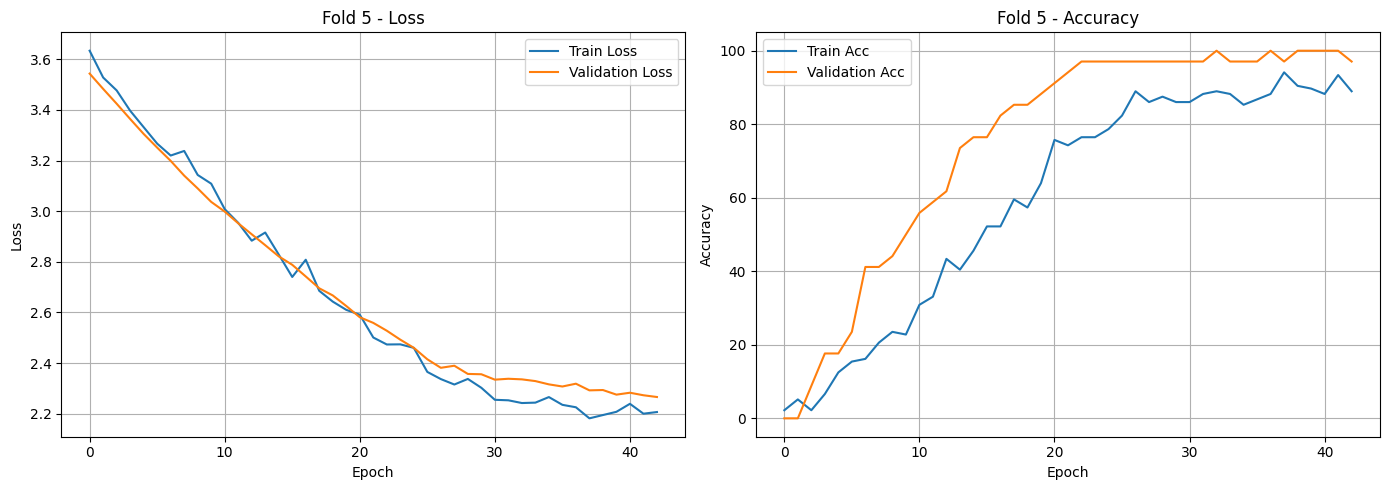

In [23]:
# === Setup ===
os.makedirs("saved_models", exist_ok=True)

cv_results = {
    "fold": [],
    "best_epoch": [],
    "best_val_accuracy": []
}

fold_accuracies = []

# Track overall best model across all folds
overall_best_model_state = None
overall_best_accuracy = 0.0
overall_best_fold = -1

# === Loop Over Folds ===
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n===== Fold {fold+1}/{NUM_FOLDS} =====")

    train_dataset = Subset(full_dataset, train_idx)
    val_dataset = Subset(full_dataset, val_idx)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    classification_model = EmbeddingClassifierBN(EMBEDDING_DIM, NUM_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, classification_model.parameters()), 
        lr=LEARNING_RATE, 
        weight_decay=WEIGHT_DECAY
    )
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

    best_val_accuracy = 0.0
    best_epoch = -1
    early_stop_counter = 0
    early_stop_patience = 10
    epsilon = 1e-4

    # === Initialize History Dict ===
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(EPOCHS):
        classification_model.train()
        running_loss_train = 0.0
        all_train_preds, all_train_labels = [], []

        for batch in train_loader:
            embeddings, labels = batch
            embeddings, labels = embeddings.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = classification_model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss_train += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            all_train_preds.append(preds.cpu())
            all_train_labels.append(labels.cpu())

        train_loss = running_loss_train / len(train_loader.dataset)
        train_acc = accuracy_fn(torch.cat(all_train_labels), torch.cat(all_train_preds))

        classification_model.eval()
        running_loss_val = 0.0
        all_val_preds, all_val_labels = [], []

        with torch.no_grad():
            for batch in val_loader:
                embeddings, labels = batch
                embeddings, labels = embeddings.to(device), labels.to(device)
                outputs = classification_model(embeddings)
                loss = criterion(outputs, labels)

                running_loss_val += loss.item() * labels.size(0)
                _, preds = torch.max(outputs, 1)
                all_val_preds.append(preds.cpu())
                all_val_labels.append(labels.cpu())

        val_loss = running_loss_val / len(val_loader.dataset)
        val_acc = accuracy_fn(torch.cat(all_val_labels), torch.cat(all_val_preds))

        # Save history for plotting
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        scheduler.step(val_acc)

        print(f"Epoch {epoch+1:02d}: Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

        if val_acc > best_val_accuracy + epsilon:
            best_val_accuracy = val_acc
            best_epoch = epoch + 1
            early_stop_counter = 0

            # Save if it's the best model across ALL folds
            if val_acc > overall_best_accuracy:
                overall_best_accuracy = val_acc
                overall_best_model_state = classification_model.state_dict()
                overall_best_fold = fold + 1

        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stop_patience:
                print(f"\nEarly stopping triggered at epoch {epoch+1}. Best at epoch {best_epoch}.")
                break

    fold_accuracies.append(best_val_accuracy)
    print(f" Fold {fold+1} finished. Best Val Acc: {best_val_accuracy:.2f}%")

    # Save fold metrics
    cv_results["fold"].append(fold + 1)
    cv_results["best_epoch"].append(best_epoch)
    cv_results["best_val_accuracy"].append(best_val_accuracy)

    # === Plot Training Curves for This Fold ===
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f"Fold {fold+1} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Validation Acc')
    plt.title(f"Fold {fold+1} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"saved_models/fold_{fold+1}_training_plot.png")
    plt.show()




## Saving Model

In [24]:
# === Overall Performance Summary ===
print("\n Cross-Validation Summary")
print(f" Average Accuracy: {np.mean(fold_accuracies):.2f}% ± {np.std(fold_accuracies):.2f}%")

# Save fold metrics to disk
results_df = pd.DataFrame(cv_results)
results_df.to_csv("saved_models/cv_results.csv", index=False)

with open("saved_models/cv_results.json", "w") as f:
    json.dump(cv_results, f, indent=4)

# Save the overall best model
best_model_path = f"saved_models/best_model_overall_fold_{overall_best_fold}.pt"
torch.save(overall_best_model_state, best_model_path)

print(f"\n Best model saved from Fold {overall_best_fold} with Val Acc = {overall_best_accuracy:.2f}%")
print("\n Results, plots, and best model saved in 'saved_models/'")


 Cross-Validation Summary
 Average Accuracy: 98.82% ± 1.44%

 Best model saved from Fold 2 with Val Acc = 100.00%

 Results, plots, and best model saved in 'saved_models/'


In [3]:
from collections import Counter

data = torch.load("final_dataset.pt")
y = data["labels"].numpy()
counts = Counter(y)

print("🎙️ Speaker sample count:")
for label, count in sorted(counts.items()):
    print(f"Speaker {label}: {count} samples")


🎙️ Speaker sample count:
Speaker 0: 5 samples
Speaker 1: 5 samples
Speaker 2: 5 samples
Speaker 3: 5 samples
Speaker 4: 5 samples
Speaker 5: 5 samples
Speaker 6: 5 samples
Speaker 7: 5 samples
Speaker 8: 5 samples
Speaker 9: 5 samples
Speaker 10: 5 samples
Speaker 11: 5 samples
Speaker 12: 5 samples
Speaker 13: 5 samples
Speaker 14: 5 samples
Speaker 15: 5 samples
Speaker 16: 5 samples
Speaker 17: 5 samples
Speaker 18: 5 samples
Speaker 19: 5 samples
Speaker 20: 5 samples
Speaker 21: 5 samples
Speaker 22: 5 samples
Speaker 23: 5 samples
Speaker 24: 5 samples
Speaker 25: 5 samples
Speaker 26: 5 samples
Speaker 27: 5 samples
Speaker 28: 5 samples
Speaker 29: 5 samples
Speaker 30: 5 samples
Speaker 31: 5 samples
Speaker 32: 5 samples
Speaker 33: 5 samples


C:\Users\jermi\AppData\Local\Temp\ipykernel_28684\3201528937.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("final_dataset.pt")


In [4]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

X = data["embeddings"].numpy()
y = data["labels"].numpy()

# Create a pipeline: scale + classify
clf = make_pipeline(StandardScaler(), SVC(kernel="linear", probability=True))

# Use Stratified 5-Fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, cv=skf)

print("✅ Cross-Validation Scores:", scores)
print("📊 Mean Accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))


✅ Cross-Validation Scores: [1. 1. 1. 1. 1.]
📊 Mean Accuracy: 1.0000 ± 0.0000


c:\Users\jermi\.conda\envs\pytorch_env\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jermi\.conda\envs\pytorch_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\jermi\.conda\envs\pytorch_env\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\jermi\.conda\envs\pytorch_env\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\jermi\.conda\envs\pytorch_env\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePr

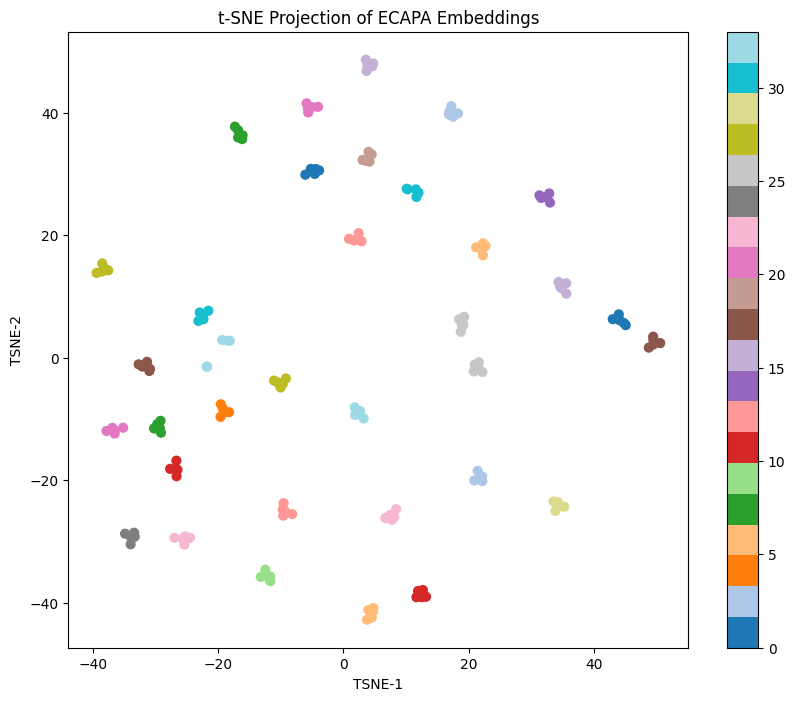

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = data["embeddings"].numpy()
y = data["labels"].numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='tab20', s=40)
plt.title("t-SNE Projection of ECAPA Embeddings")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.colorbar(scatter)
plt.show()
